导入需要使用的库

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import jieba
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

Colab将简体中文数据集导入，此本地简体中文txt文件由以下链接

http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip

繁体中文转换而成


In [2]:
path_to_file = "../content/sample_data/cmn_simple.txt"

将 unicode 文件转换为 ascii

出现乱码，把Unicode形式的中文字符串输入到文本中则会出现乱码现象。

解决中文符号的乱码问题，以及计算机存储是数字

并将其标准化

In [3]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')


进行文字处理：

最后一个标点符号前插入空格，并用空格替换所有语句外的符号，此时空格冗余，再删除多余的空格符

将句子加上开始与结束标记，对模型的开始与结束进行定义

具体代码细节语句见注释



In [4]:
#文字处理
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # 在单词与跟在其后的标点符号之间插入一个空格，即用空白填充标点符号
    # 例如： "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格
    #w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    str = " "
    w = jieba.cut(w)
    w = str.join(w)
    #删去多余空格
    w = ' '.join(w.split())
    w = w.rstrip().strip()

    # 给句子加上开始和结束标记
    # 以便模型知道何时开始和结束预测
    w = '<start> ' + w + ' <end>'
    print(w)
    return w

与Tensorflow2.0官网的西班牙语相同，对以上代码块进行中文简体与英语的文字处理测试

In [5]:
#tensorflow2.0文字处理测试
en_sentence = u"There are millions of roads, but safety comes first."
cmn_sentence = u"道路千万条，安全第一条。"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(cmn_sentence).encode('utf-8'))

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.777 seconds.
DEBUG:jieba:Loading model cost 0.777 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


<start> there are millions of roads , but safety comes first . <end>
<start> there are millions of roads , but safety comes first . <end>
<start> 道路 千万条 ， 安全 第一条 。 <end>
b'<start> \xe9\x81\x93\xe8\xb7\xaf \xe5\x8d\x83\xe4\xb8\x87\xe6\x9d\xa1 \xef\xbc\x8c \xe5\xae\x89\xe5\x85\xa8 \xe7\xac\xac\xe4\xb8\x80\xe6\x9d\xa1 \xe3\x80\x82 <end>'


一一对应清理句子，并返回 [ENGLISH, CHINSES] 单词对

In [6]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]

    return zip(*word_pairs)

根据数据集中的文字长度，定义目标张量最大长度

In [7]:
def max_length(tensor):
    return max(len(t) for t in tensor)

将数据集中的单词文字转化为令牌词典/词汇表

即将翻译问题转化为数学问题

In [8]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                           padding='post')
    return tensor, lang_tokenizer


加载数据集，记录输入输出张量，并创建输入输出对的词典

In [9]:
def load_dataset(path, num_examples=None):
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

定义不同大小的数据集

In [10]:
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

流式输出内容被截断，只能显示最后 5000 行内容。
<start> he often sits for many hours reading books . <end>
<start> 他 常常 坐 着 看书 一连 好几个 小时 。 <end>
<start> her hair grew back to it ' s original length . <end>
<start> 她 的 头发 长回 原来 的 长度 了 。 <end>
<start> his decision to retire surprised all of us . <end>
<start> 他 要 退休 的 决定 让 我们 都 感到 吃惊 。 <end>
<start> his influence extends all over the country . <end>
<start> 他 的 影响 遍及 全国 。 <end>
<start> his store is always crowded with customers . <end>
<start> 他 的 店 总是 挤满 了 顾客 。 <end>
<start> his teeth are yellow from smoking too much . <end>
<start> 他 的 牙齿 被 烟熏 黄了 。 <end>
<start> how could i be a robot ? robots can ' t dream . <end>
<start> 我 怎么 可能 是 机器人 呢 ？ 机器人 不会 做梦 。 <end>
<start> how many students are there in your school ? <end>
<start> 你们 学校 有 多少 学生 ？ <end>
<start> i almost always play baseball after school . <end>
<start> 我 几乎 总是 在 放学 后 打 棒球 。 <end>
<start> i can ' t tell you how to pronounce the word . <end>
<start> 我 不 知道 怎么 告诉 你 这个 词 的 发音 。 <end>
<start> i conside

得出输入与输出的目标张量的最大长度:max_length

In [11]:
# 计算目标张量的最大长度 （max_length）
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

采用8:2的比例切分训练集和验证集

In [12]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor,target_tensor,test_size=0.2)

参数设置

初始化BUFFER_SIZE：加入缓冲器的元素的最大数

初始化BATCH_SIZE：单次传递给程序用以训练的数据(样本)个数

初始化steps_per_epoch：每一个epoch训练一次需要的次数，即数据集除以批次大小得出

初始化embedding_dim：映射，语义空间到向量空间的映射

初始化units：每层神经网络中神经元的个数，注：其是向量，有多个值

初始化vocab_inp_size：输入的词典大小，对应中文

初始化vocab_tar_size：输出的词典大小，对应英文

In [13]:
BUFFER_SIZE=len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

接收tensor，对tensor的第一维度进行切分，并返回一个表示该tensor的切片数据集，并随机

In [14]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

定义encoder编码器，对输入序列编码

In [15]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))


encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

使用attention机制

In [16]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # 隐藏层的形状 == （批大小，隐藏层大小）
        # hidden_with_time_axis 的形状 == （批大小，1，隐藏层大小）
        # 这样做是为了执行加法以计算分数
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # 分数的形状 == （批大小，最大长度，1）
        # 我们在最后一个轴上得到 1， 因为我们把分数应用于 self.V
        # 在应用 self.V 之前，张量的形状是（批大小，最大长度，单位）
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # 注意力权重 （attention_weights） 的形状 == （批大小，最大长度，1）
        attention_weights = tf.nn.softmax(score, axis=1)

        # 上下文向量 （context_vector） 求和之后的形状 == （批大小，隐藏层大小）
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


attention_layer = BahdanauAttention(10)

定义deccoder解码器，对输出层解码为序列

In [17]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # 用于注意力
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # 编码器输出 （enc_output） 的形状 == （批大小，最大长度，隐藏层大小）
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x 在通过嵌入层后的形状 == （批大小，1，嵌入维度）
        x = self.embedding(x)

        # x 在拼接 （concatenation） 后的形状 == （批大小，1，嵌入维度 + 隐藏层大小）
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # 将合并后的向量传送到 GRU
        output, state = self.gru(x)

        # 输出的形状 == （批大小 * 1，隐藏层大小）
        output = tf.reshape(output, (-1, output.shape[2]))

        # 输出的形状 == （批大小，vocab）
        x = self.fc(output)

        return x, state, attention_weights


decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)


选择Adam优化器

将数字编码转化成one-hot编码格式，然后对one-hot编码格式的数据（真实标签值）与预测出的标签值使用交叉熵损失函数

并定义损失函数


In [18]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

检查点初始化

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


定义训练函数

In [20]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        # 教师强制 - 将目标词作为下一个输入
        for t in range(1, targ.shape[1]):
            # 将编码器输出 （enc_output） 传送至解码器
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)
            # 使用教师强制
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss


定义训练次数并开始训练

In [21]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # 每 2 个周期（epoch），保存（检查点）一次模型
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))



Epoch 1 Batch 0 Loss 1.8539
Epoch 1 Batch 100 Loss 0.9034
Epoch 1 Batch 200 Loss 0.9228
Epoch 1 Loss 1.0173
Time taken for 1 epoch 145.9683232307434 sec

Epoch 2 Batch 0 Loss 0.8805
Epoch 2 Batch 100 Loss 0.7721
Epoch 2 Batch 200 Loss 0.7360
Epoch 2 Loss 0.7839
Time taken for 1 epoch 87.20894622802734 sec

Epoch 3 Batch 0 Loss 0.6791
Epoch 3 Batch 100 Loss 0.6325
Epoch 3 Batch 200 Loss 0.6664
Epoch 3 Loss 0.6609
Time taken for 1 epoch 86.16403555870056 sec

Epoch 4 Batch 0 Loss 0.5954
Epoch 4 Batch 100 Loss 0.5934
Epoch 4 Batch 200 Loss 0.5353
Epoch 4 Loss 0.5461
Time taken for 1 epoch 86.90523386001587 sec

Epoch 5 Batch 0 Loss 0.4395
Epoch 5 Batch 100 Loss 0.5137
Epoch 5 Batch 200 Loss 0.4555
Epoch 5 Loss 0.4386
Time taken for 1 epoch 86.1286551952362 sec

Epoch 6 Batch 0 Loss 0.3381
Epoch 6 Batch 100 Loss 0.3687
Epoch 6 Batch 200 Loss 0.3766
Epoch 6 Loss 0.3416
Time taken for 1 epoch 86.87649345397949 sec

Epoch 7 Batch 0 Loss 0.3026
Epoch 7 Batch 100 Loss 0.2805
Epoch 7 Batch 200 L

预测函数的定义

In [22]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        # 存储注意力权重以便后面制图
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        # 预测的 ID 被输送回模型
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot


绘制注意力权重图

In [23]:
# 注意力权重制图函数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

翻译函数

In [24]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))


<start> 这是 一封信 <end>
Input: <start> 这是 一封信 <end>
Predicted translation: this is a letter . <end> 


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36825 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 26159 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 19968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23553 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 36825 missing from current font.
  font.set_

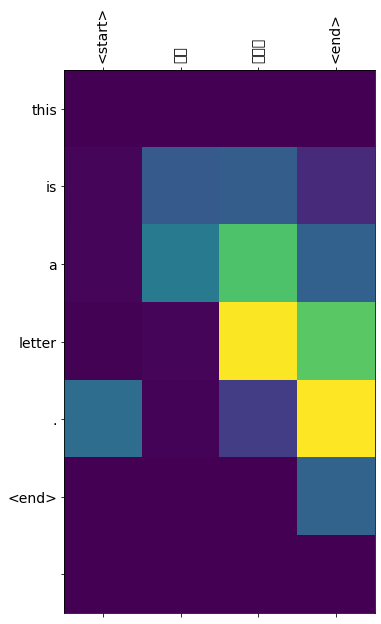

<start> 许多 学生 喜欢 在 早上 学习 <end>
Input: <start> 许多 学生 喜欢 在 早上 学习 <end>
Predicted translation: many students like to study in the morning . <end> 


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35768 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22810 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29983 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 21916 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27426 missing from current font.
  font.set_

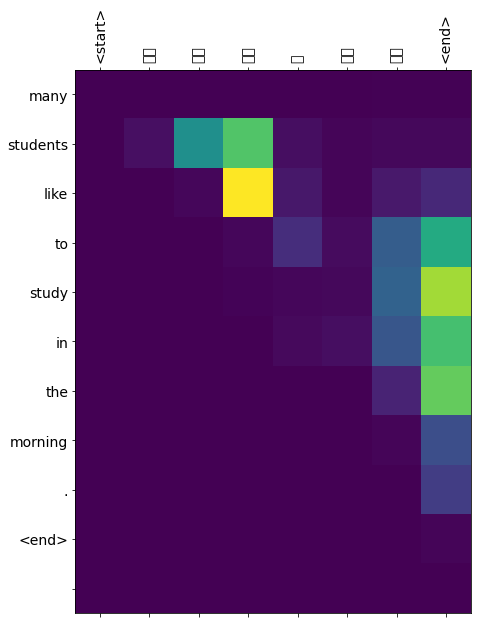

<start> 汤姆 说 他 乐意 做 这事 <end>
Input: <start> 汤姆 说 他 乐意 做 这事 <end>
Predicted translation: tom said he ' d be willing to do this . <end> 


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27748 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22982 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20182 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20048 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24847 missing from current font.
  font.set_

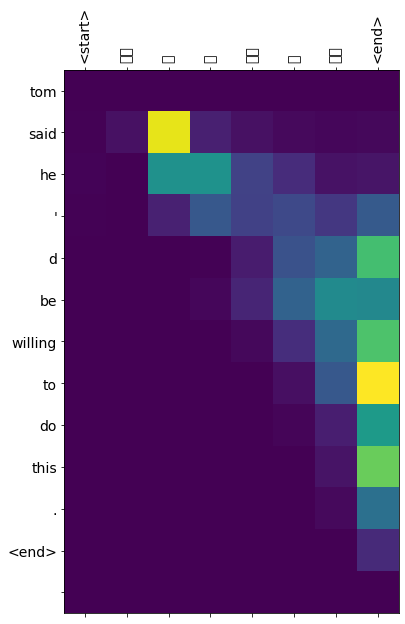

<start> 公园 里 下 了 好多 雪 <end>
Input: <start> 公园 里 下 了 好多 雪 <end>
Predicted translation: there was a lot in the park . <end> 


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20844 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 37324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 19979 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20102 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22909 missing from current font.
  font.set_

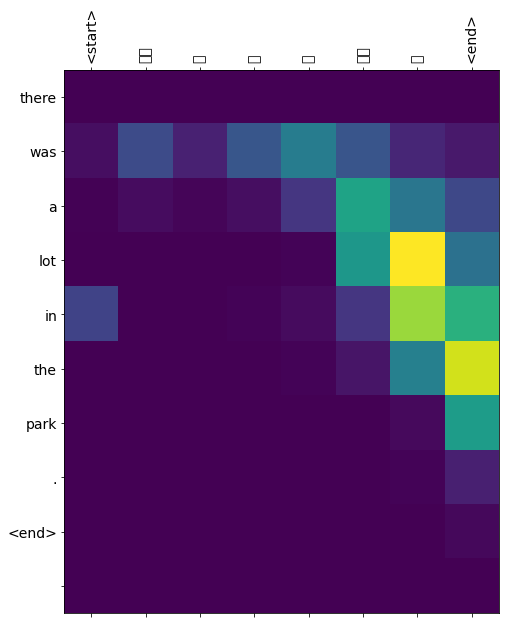

In [25]:

# 恢复检查点目录 （checkpoint_dir） 中最新的检查点？？？中文用不了
# 检查点checkpoint中存储着模型model所使用的的所有的 tf.Variable 对象，
# 它不包含任何关于模型的计算信息，因此只有在源代码可用，也就是我们可以恢复原模型结构的时候，checkpoint才有用，
# 否则不知道模型的结构，仅仅只知道一些Variable是没有意义的。
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


translate(u'这是一封信')
translate(u'许多学生喜欢在早上学习')
translate(u'汤姆说他乐意做这事')
translate(u'公园里下了好多雪')
